# Analyse BlueSeis BSPF Event Analysis - Coherence

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __rolling_average(arr, win_size=5):

    from numpy import ones, array
    from scipy.signal import convolve, hanning

    data = array(arr)
    window = ones(win_size)/float(win_size)
    window = hanning(win_size)/float(win_size)
    rolling_average = convolve(data, window, mode='valid')

    return rolling_average

## Configurations

In [4]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## 
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/velocity/"


## Load Data

In [5]:
# !ls /home/andbro/kilauea-data/BSPF/data/catalogs/

### load event and trigger data

In [6]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_all.xml")

triggered = pd.read_pickle(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_triggered.pkl")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

### select event

In [7]:
num = 1

event_time = event_times.origin_time.loc[num]

event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

trig = triggered[triggered.origin == event_time]

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

### load stream

In [8]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

# st.detrend("simple")

# config['fmin'], config['fmax'] = 5.0, 50.0
# st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)


cut_offs = [
    (65,80), (65,80), (60,100), (60,100), (60,70),
    (60,90), (60,90), (60,90), (62,105), (65,90),
    (62,110), (65,85), (60,105),
]

st.trim(st[0].stats.starttime+cut_offs[num][0], st[0].stats.endtime-cut_offs[num][1]);

In [9]:
st

12 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.PFO.10.BHN  | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.PFO.10.BHZ  | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.al.BJE | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.al.BJN | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.al.BJZ | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.in.BJE | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.in.BJN | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.in.BJZ | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
PY.BSPF..HJE   | 2022-10-07T22:45:10.472300Z - 2022-10-07T22:45:45.472300Z | 40.0 Hz, 

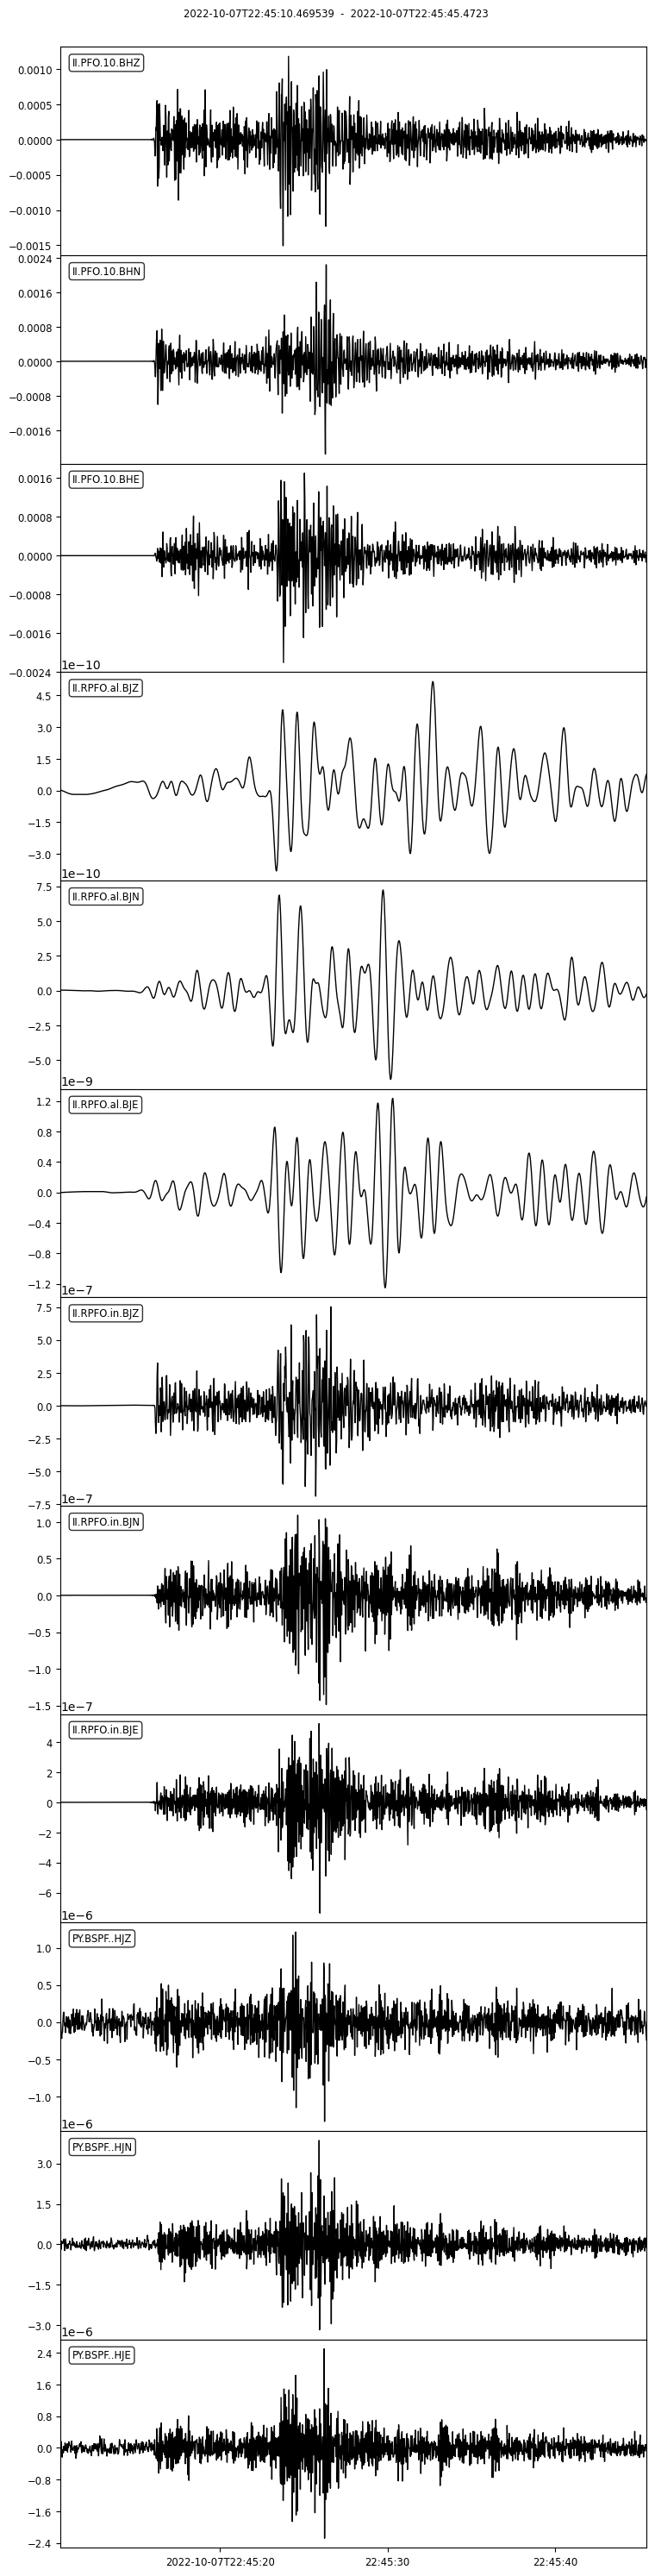

In [10]:
st.plot(equal_scale=False);

## Coherence


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 7240 is greater than input length  = 1401, using nperseg = 1401
  .format(nperseg, input_length))
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 6440 is greater than input length  = 1401, using nperseg = 1401
  .format(nperseg, input_length))
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 5640 is greater than input length  = 1401, using nperseg = 1401
  .format(nperseg, input_length))
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 4840 is greater than input length  = 1401, using n

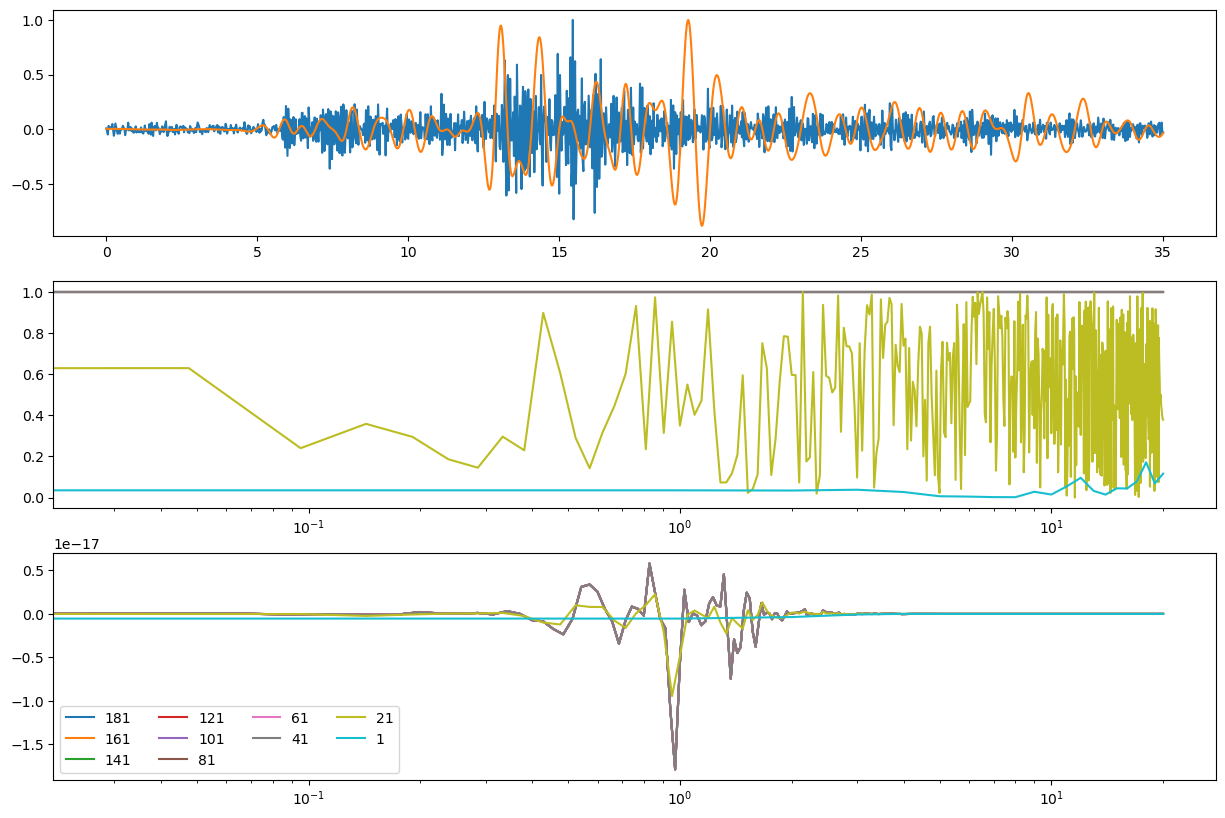

In [11]:
from scipy.signal import coherence, csd

s1 = st.select(station="BSPF", channel="*N")[0]
s2 = st.select(station="RPFO", location="al", channel="*N")[0]

df = s1.stats.sampling_rate

fig, ax = plt.subplots(3,1, figsize=(15,10))

ax[0].plot(s1.times(), s1.data/max(s1.data))
ax[0].plot(s2.times(), s2.data/max(s2.data))

for tseg in reversed(np.arange(1, 200, 20)):

    nseg = int(df*tseg)
    nover = int(0.5*nseg)


    fcoh, coh = coherence(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=None)
    fcsd, css = csd(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=None)

    ax[1].semilogx(fcoh, coh, label=tseg)
    ax[2].semilogx(fcsd, css, label=tseg)
    
plt.legend(ncol=4)
plt.show();


## CrossSpectralDensity

In [32]:
def __csd_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):
   
    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import csd
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}
    
    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
    df_out = DataFrame()
    
    if plot:
        NN = 5
        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])
    
    rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"
    font = 15
    
    fmin_i, fmax_i = 1.0, 16.0 ## 0.16, 16.5
    fmin_a, fmax_a = 0.1, 1.0  ## 0.02, 1.3
    
    plt.subplots_adjust(hspace=0.2)    
    plt.figure()
    
    for ii, comp in enumerate(["Z","N","E"]):

        tr0 = st_in.select(station="BSPF", channel=f'*{comp}').copy()[0]
        tr1 = st_in.select(station="BSPF", channel=f'*{comp}').copy()[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}').copy()[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}').copy()[0]
        

        tr0 = tr0.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)

        if normalize:
            tr0 = tr0.normalize()
            tr1 = tr1.normalize()        
            tr2 = tr2.normalize()        
            tr3 = tr3.normalize()        
            rot_scale, rot_unit = 1, r"rad/s"
    
        co2, co3 = [],[]
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()
            
#             s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            
#             s0 = s0.normalize()            
#             s1 = s1.normalize()
#             s2 = s2.normalize()
#             s3 = s3.normalize()

#             s1 = s1.taper(0.1)
#             s2 = s2.taper(0.1)
#             s3 = s3.taper(0.1)
            
            df = s1.stats.sampling_rate
        
            tseg = 1/fcenter[nn]*5
            nseg = int(df*tseg) if int(df*tseg) < len(s1.data) else len(s1.data)
            nover = int(0.5*nseg)
                            
            ff2, coh2 = csd(s0.data, s2.data, fs=df, window='hann', nperseg=nseg, noverlap=nover, scaling="spectrum")
            ff3, coh3 = csd(s1.data, s3.data, fs=df, window='hann', nperseg=nseg, noverlap=nover, scaling="spectrum")
#             ff2, coh2 = csd(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = csd(s1.data, s3.data, fs=df, window='hann')
        

            for i in range(len(ff2)):
                if ff2[i] <= fl or ff2[i] >= fu:
                    coh2[i], coh3[i] = nan, nan
        
            
            co2.append(nanmax(abs(coh2)))
            co3.append(nanmax(abs(coh3)))
            
        if plot:
            
            adr_inner = r"ADR$_{inner}$"
            
            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}", alpha=0.7)

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}", alpha=0.7)
                
            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}", alpha=0.7)

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}", alpha=0.7)
                
            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}", alpha=0.7)

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}", alpha=0.7)
                
            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)
                
            ax7.scatter(fcenter, co2, s=50, marker="s", label="BSPF-RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, co3, s=50, label="BSPF-PRFO_all", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co3, ls=":", color=colors[comp])

            ax7.legend(ncol=3)

            ax7.set_xscale("log")
            ax7.set_yscale("log")
            
            ax7.grid(ls="--",zorder=0,alpha=.5, which="both")
            
            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrt_hz})", fontsize=font)
            
            ax1.set_title(f"inner array ({fmin_i} - {fmax_i} Hz)", fontsize=font+1)
            ax4.set_title(f"total array ({fmin_a} - {fmax_a} Hz)", fontsize=font+1)
            
                
        ## prepare output
        df_out[f'{comp}_in_fc'] = fcenter
        df_out[f'{comp}_in_co']  = co2
        df_out[f'{comp}_al_fc'] = fcenter
        df_out[f'{comp}_al_co']  = co3
        
        
    plt.show();        

        
    return df_out

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: All-NaN slice encountered
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: All-NaN slice encountered
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored

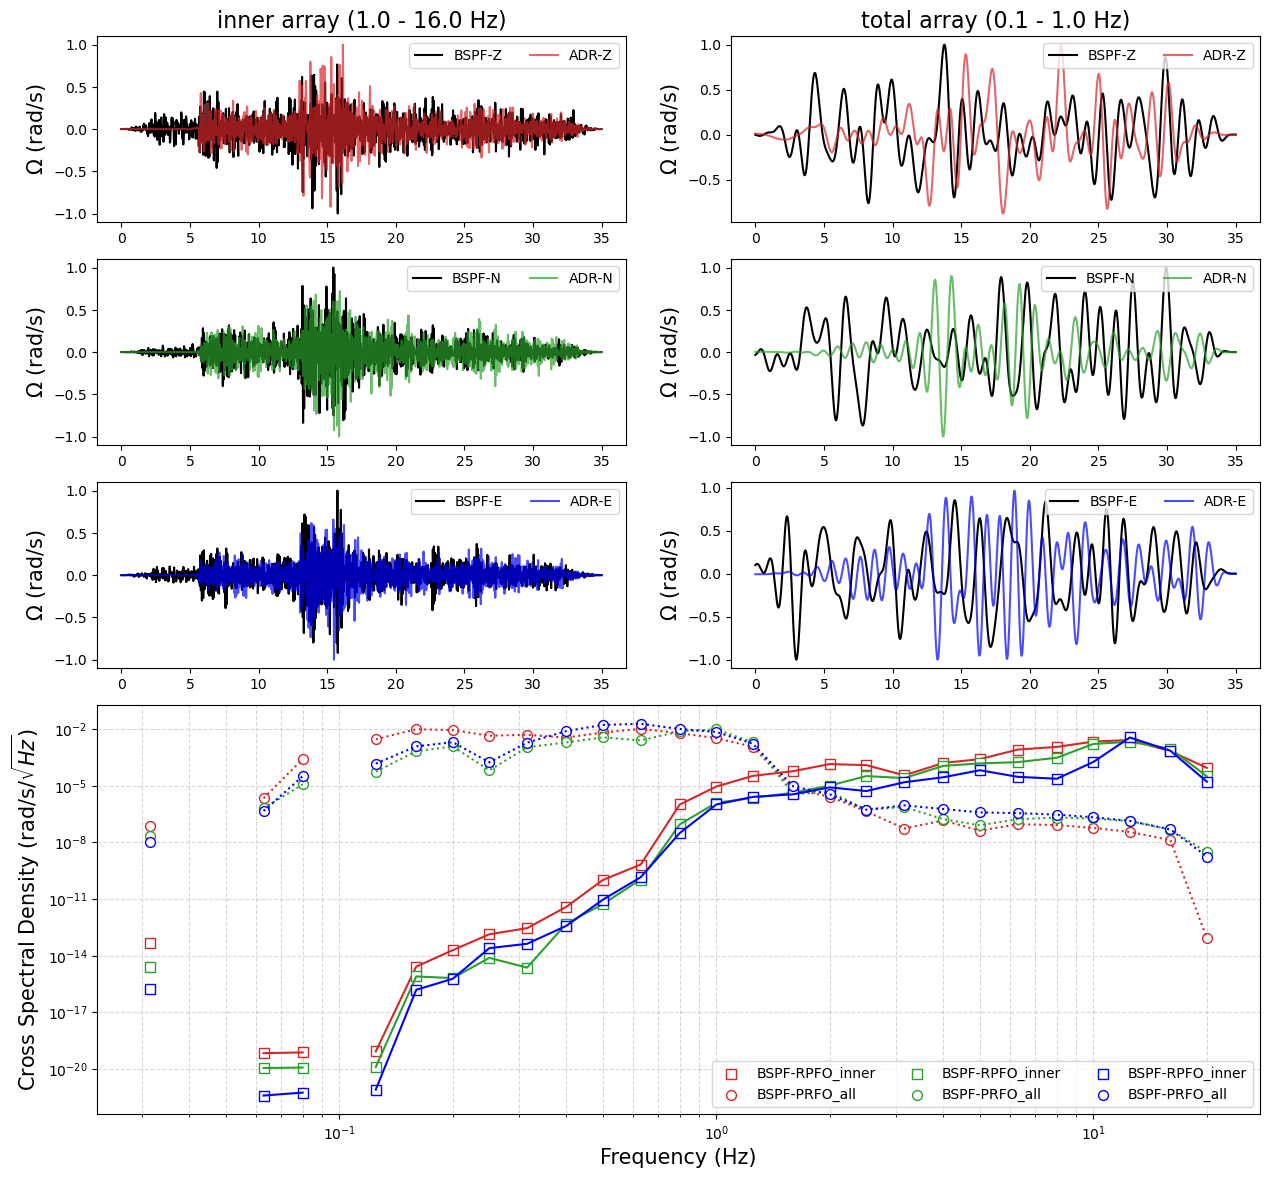

<Figure size 640x480 with 0 Axes>

In [33]:
fmin, fmax = 0.02, 18

df_coh = __csd_in_octaves(st, fmin, fmax, normalize=True, plot=True)

## Coherence

In [ ]:
def __coherence_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):
   
    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}
    
    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
    df_out = DataFrame()
    
    if plot:
        NN = 5
        font = 15
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"
    
        fmin_i, fmax_i = 1.0, 16.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.1, 1.0  ## 0.02, 1.3
    
        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])
        
        plt.subplots_adjust(hspace=0.2)
        
        
    
    for ii, comp in enumerate(["Z","N","E"]):

        tr0 = st_in.select(station="BSPF", channel=f'*{comp}').copy()[0]
        tr1 = st_in.select(station="BSPF", channel=f'*{comp}').copy()[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}').copy()[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}').copy()[0]
        
        tr0 = tr0.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.1).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)

        if normalize:
            tr0 = tr0.normalize()
            tr1 = tr1.normalize()        
            tr2 = tr2.normalize()        
            tr3 = tr3.normalize()           
            rot_scale, rot_unit = 1, r"rad/s"
            
        co2, co3 = [],[]
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

#             s0 = s0.taper(0.1)
#             s1 = s1.taper(0.1)
#             s2 = s2.taper(0.1)
#             s3 = s3.taper(0.1)

#             s0 = s0.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)            
#             s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)


            
            df = s1.stats.sampling_rate
        
            tseg = 1/fcenter[nn]*5
            nseg = int(df*tseg) if int(df*tseg) < len(s1.data) else len(s1.data)
            nover = int(0.5*nseg)
                            
            ff2, coh2 = coherence(s0.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=nover)
            ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann',nperseg=nseg, noverlap=nover)
            
#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')
        
            for i in range(len(ff2)):
                if ff2[i] <= fl or ff2[i] >= fu:
                    coh2[i], coh3[i] = nan, nan
        
            plt.semilogx(ff2, coh2)
            
            co2.append(nanmax(coh2))
            co3.append(nanmax(coh3))
            
        if plot:
            
            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")
                
            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")
                
            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")
                
            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)
                
            ax7.scatter(fcenter, co2, s=50, marker="s", label="BSPF-RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, co3, s=50, label="BSPF-PRFO_all", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co3, ls=":", color=colors[comp])

            ax7.legend(ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--",zorder=0,alpha=.5, which="both")
            
            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            
            ax1.set_title(f"inner array ({fmin_i} - {fmax_i} Hz)", fontsize=font+1)
            ax4.set_title(f"total array ({fmin_a} - {fmax_a} Hz)", fontsize=font+1)
            
        ## prepare output
        df_out[f'{comp}_in_fc'] = fcenter
        df_out[f'{comp}_in_co']  = co2
        df_out[f'{comp}_al_fc'] = fcenter
        df_out[f'{comp}_al_co']  = co3
        
        
    plt.show();        

        
    return df_out

In [ ]:
fmin, fmax = 0.1, 18

df_coh = __coherence_in_octaves(st, fmin, fmax, normalize=True)

## Plot CSD

In [ ]:
def __makeplotStream_csd2(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,14))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[] 
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
                
        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        bspf_inner.normalize()
        
        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        adr_inner.normalize()
        
        nseg = int(5*tmp[0].stats.sampling_rate)
        
        ff, Pxy = csd(  
                        bspf_inner.data,
                        adr_inner.data,
                        fs=bspf_inner.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='density',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)
        
        ## _____________________________________
        
        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")        
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        adr_all.normalize()        
            
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff2, Pxy2 = csd(  
                        bspf_all.data*rot_scaling,
                        adr_all.data*rot_scaling,
                        fs=bspf_all.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='spectrum',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")
        
        ffs.append(ff2)
        csds.append(Pxy2)
        
        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)
        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:       
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
            

#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
    
    ax7.set_xscale("log")   
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.1, 20)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)
    
    
    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

4 Trace(s) in Stream:
PY.BSPF..HJZ   | 2022-10-07T22:45:10.472300Z - 2022-10-07T22:45:45.472300Z | 40.0 Hz, 1401 samples
II.RPFO.al.BJZ | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.in.BJZ | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.PFO.10.BHZ  | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
4 Trace(s) in Stream:
PY.BSPF..HJN   | 2022-10-07T22:45:10.472300Z - 2022-10-07T22:45:45.472300Z | 40.0 Hz, 1401 samples
II.RPFO.al.BJN | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.RPFO.in.BJN | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
II.PFO.10.BHN  | 2022-10-07T22:45:10.469539Z - 2022-10-07T22:45:45.469539Z | 40.0 Hz, 1401 samples
4 Trace(s) in Stream:
PY.BSPF..HJE   | 2022-10-07T22:45:10.472300Z - 2022-10-07T22:45:45.472300Z | 40.0 Hz, 1401 samples
II.RPFO.al.BJE | 2022-10-07T22:45:10.469539

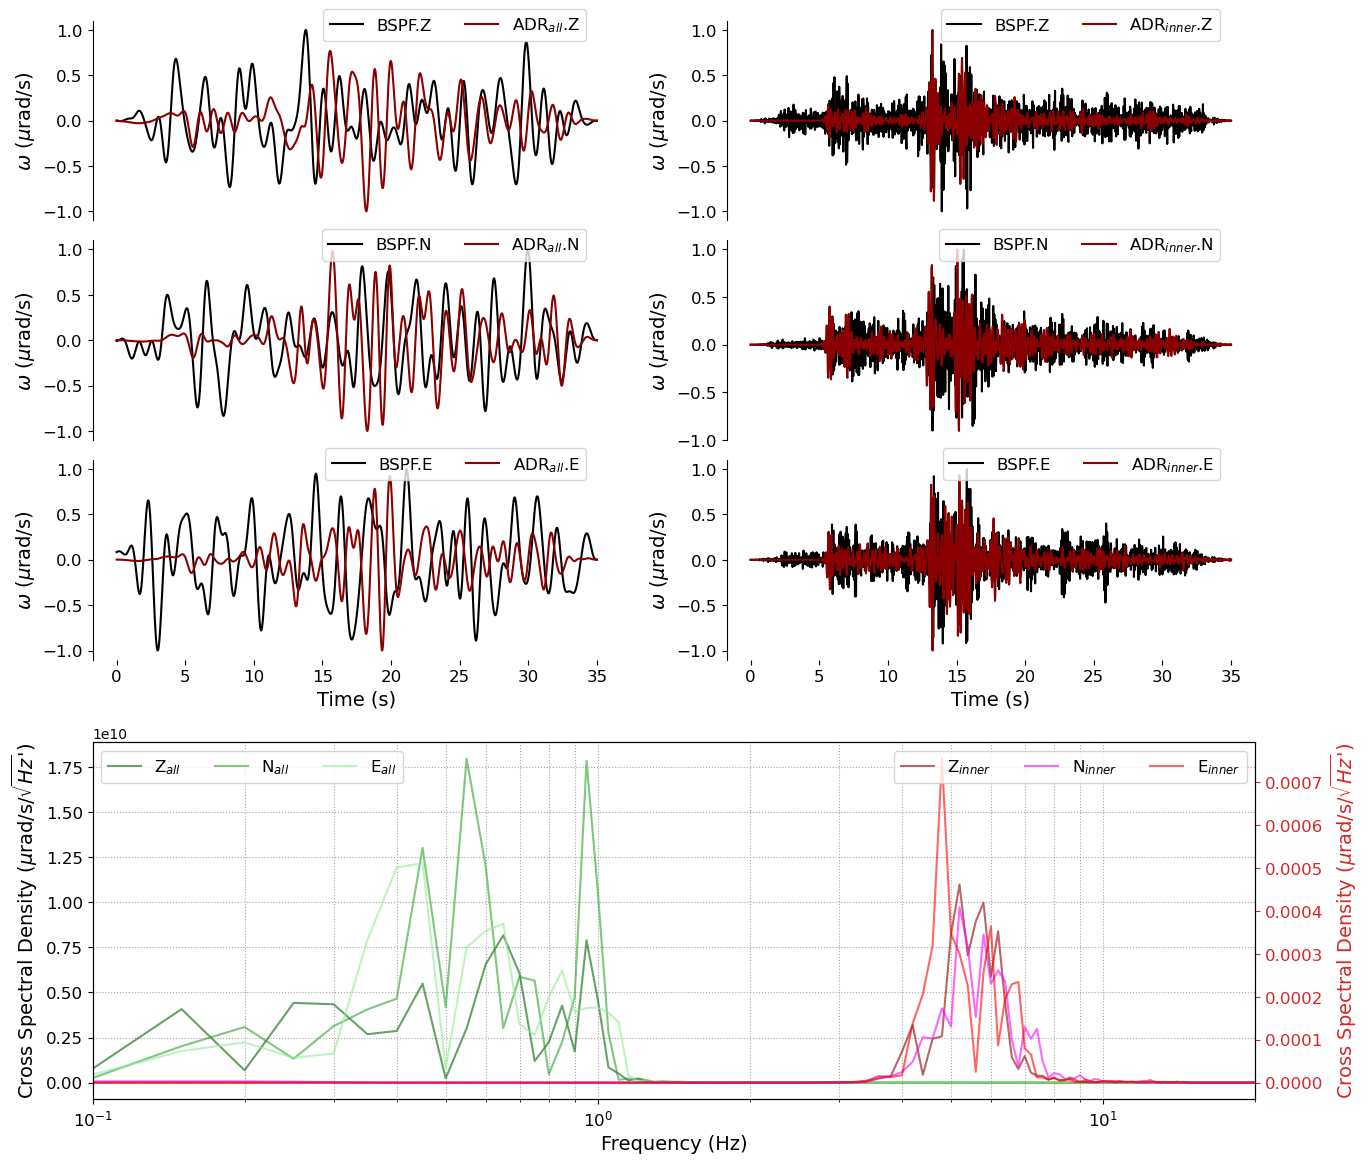

In [34]:
__makeplotStream_csd2(st, config);

## Cross Correlation

In [18]:
def __cc_in_octaves(st_in, fmin, fmax):

    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from functions.compute_cc_for_fbands import __compute_cc_for_fbands
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    ## _____________________

#     fbands = [(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,11),(8,12),(9,13),(10,14),(11,15),(12,16),(13,17),(14,18)]
#     fbands = [(1,2),(2,4),(3,6),(4,8),(5,10),(6,12),(7,14),(8,16), (9,18), (10,20)]

    df_out = DataFrame()
    
    for comp in ["Z","N","E"]:

        print(comp)

        plt.figure(figsize=(15,5))

        tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        
        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr2, fbands=fbands, plot=False)
        
        df_out[f'{comp}_in_fband'] = ff
        df_out[f'{comp}_in_cc_t'] = cc_t_max
        df_out[f'{comp}_in_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max, color="r")
        plt.scatter(ff, cc_f_max, color="r")

        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr3, fbands=fbands, plot=False)

        df_out[f'{comp}_al_fband'] = ff
        df_out[f'{comp}_al_cc_t'] = cc_t_max
        df_out[f'{comp}_al_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max)
        plt.scatter(ff, cc_f_max) 

    #     plt.xscale("log")
        plt.show()
        
    return df_out

Z


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (22.44924096618746) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


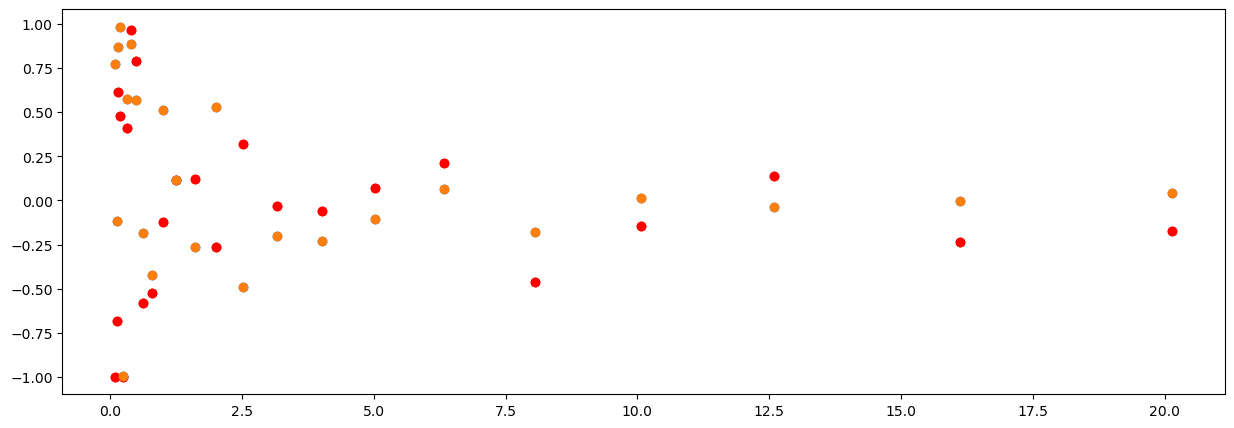

N


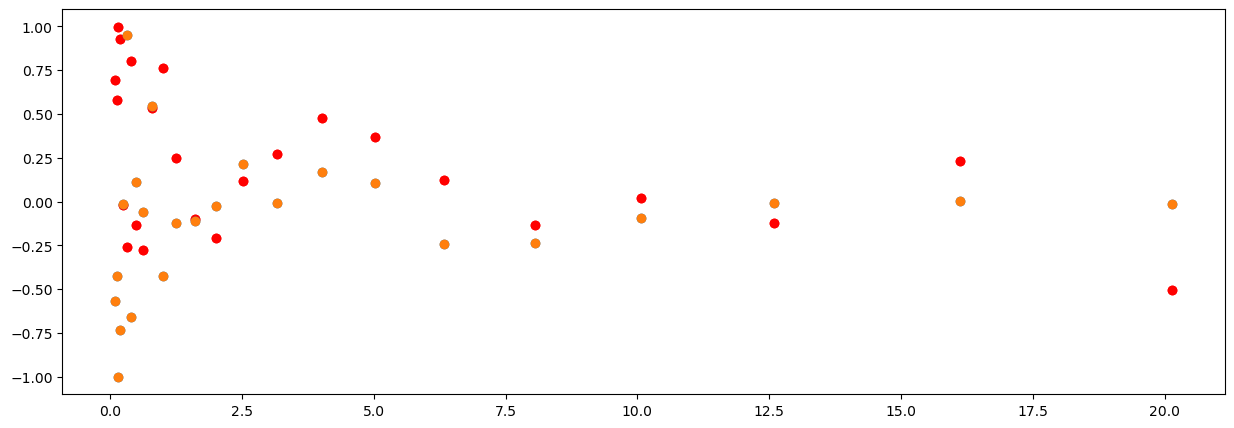

E


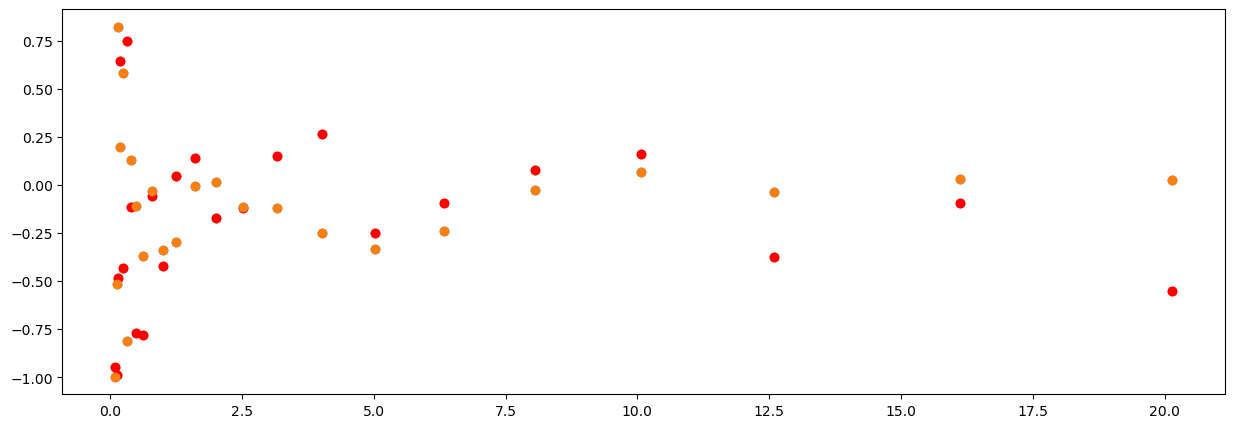

,Z_in_fband,Z_in_cc_t,Z_in_cc_f,Z_al_fband,Z_al_cc_t,Z_al_cc_f,N_in_fband,N_in_cc_t,N_in_cc_f,N_al_fband,N_al_cc_t,N_al_cc_f,E_in_fband,E_in_cc_t,E_in_cc_f,E_al_fband,E_al_cc_t,E_al_cc_f
0,0.100668,-0.997376,-0.997376,0.100668,0.771185,0.771185,0.100668,0.695033,0.695033,0.100668,-0.567493,-0.567493,0.100668,-0.945373,-0.945373,0.100668,-0.997294,-0.997294
1,0.125835,-0.680004,-0.680004,0.125835,-0.117971,-0.117971,0.125835,0.580005,0.580005,0.125835,-0.424614,-0.424614,0.125835,-0.988273,-0.988273,0.125835,-0.517086,-0.517086
2,0.161069,0.615619,0.615619,0.161069,0.867871,0.867871,0.161069,0.997212,0.997212,0.161069,-0.999936,-0.999936,0.161069,-0.484072,-0.484072,0.161069,0.821942,0.821942
3,0.201336,0.478619,0.478619,0.201336,0.984178,0.984178,0.201336,0.928586,0.928586,0.201336,-0.732730,-0.732730,0.201336,0.641526,0.641526,0.201336,0.199048,0.199048
4,0.251670,-0.998750,-0.998750,0.251670,-0.996844,-0.996844,0.251670,-0.022265,-0.022265,0.251670,-0.014374,-0.014374,0.251670,-0.432318,-0.432318,0.251670,0.579347,0.579347
5,0.317104,0.412346,0.412346,0.317104,0.573001,0.573001,0.317104,-0.257264,-0.257264,0.317104,0.950330,0.950330,0.317104,0.750133,0.750133,0.317104,-0.812571,-0.812571
6,0.402672,0.967893,0.967893,0.402672,0.888319,0.888319,0.402672,0.800344,0.800344,0.402672,-0.659379,-0.659379,0.402672,-0.113338,-0.113338,0.402672,0.127768,0.127768
7,0.503340,0.789504,0.789504,0.503340,0.571592,0.571592,0.503340,-0.134055,-0.134055,0.503340,0.114044,0.114044,0.503340,-0.768171,-0.768171,0.503340,-0.110554,-0.110554
8,0.634209,-0.583015,-0.583015,0.634209,-0.184897,-0.184897,0.634209,-0.275698,-0.275698,0.634209,-0.058312,-0.058312,0.634209,-0.780415,-0.780415,0.634209,-0.367543,-0.367543
9,0.805344,-0.524024,-0.524024,0.805344,-0.419566,-0.419566,0.805344,0.534486,0.534486,0.805344,0.546771,0.546771,0.805344,-0.057774,-0.057774,0.805344,-0.032514,-0.032514


In [19]:
df_cc = __cc_in_octaves(st, fmin, fmax)
df_cc

<AxesSubplot:>

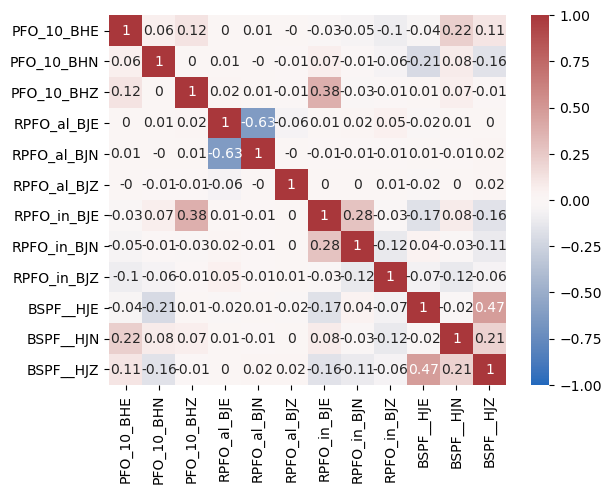

In [20]:
import seaborn as sns

def __stream_to_dataframe(st):
    
    dff = pd.DataFrame()

    for tr in st: 
        name = f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}"
        dff[name] = tr.data
        
    return dff


st00 = st.copy();
st00 = st00.detrend("linear");
st00 = st00.filter("bandpass", freqmin=0.1, freqmax=18, corners=8, zerophase=True);
# st00.plot();

dff = __stream_to_dataframe(st00)

matrix = dff.corr().round(2)

sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')

## AS LOOP

In [21]:
# for i in range(0,17):
    
#     event_time = event_times.origin_time.loc[i]
    
#     try:
#         event = events.filter(f"time >= {event_time}",f"time <= {event_time}")
        
#         event_time = event_times.origin_time.loc[i]

#         trig = triggered[triggered.origin == event_time]

#     except:
#         print(f" -> {i} no event")
        
#     ## prepare string
#     event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")
     
#     ## load data
#     st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

#     st.detrend("simple")

#     st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    
#     out['fig'].savefig(config['output_figs']+f"{event_time_str}_rayleigh_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05)